In [1]:
############################################################
# Headers
##############################

using OrdinaryDiffEq
using SpecialFunctions
using Plots
using DelimitedFiles
using Interpolations
using Base.Threads
using LaTeXStrings
using NPZ

############################################################

In [2]:
############################################################
# Constants in CGS
##############################

kb  ::Float64 = 1.38065e-16;
Msun::Float64 = 2e33;
G   ::Float64 = 6.674e-8
mp  ::Float64 = 1.67262e-24;
AU  ::Float64 = 1.49598e13
yr  ::Float64 = 365 * 86400.;

############################################################
# Basic Functions
##############################

function f_find_idx( arr, val )
    l_idx = lastindex( arr )
    if val <= first( arr )
        return firstindex( arr )
    elseif val >= arr[ l_idx ]
        return l_idx
    end
    for i in eachindex( arr )
        if arr[ i ] >= val
            return i - 1
        end
    end
    return -1
end

function f_mid( arr )
    ( arr[ begin + 1 : end ] + arr[ begin : end - 1 ] ) / 2
end

function f_dif( arr )
    ( arr[ begin + 1 : end ] - arr[ begin : end - 1 ] ) 
end

############################################################
# Velocity-related functions
##############################

function f_dv_turb( a_0, a_1, rho_s, rho_g, h, alpha, T )
    a0    = max( a_0, a_1 );
    a1    = min( a_0, a_1 );
    v_th  = sqrt( 8 * kb * T / ( pi * 2 * mp ) );
    mfp   = 2 * mp / ( 1.2e-15 * rho_g );
    cs    = sqrt( 1.4 * kb * T / ( 2 * mp ) );

    sigma_disk = 2.5 * h * rho_g;  # sqrt( 2 * pi ) ~= 2.5
    
    St_0  = ( pi / 2 * rho_s * a0 / sigma_disk
              * max( 1, 4 * a0 / ( 9 * mfp ) ) );
    St_1  = ( pi / 2 * rho_s * a1 / sigma_disk
              * max( 1, 4 * a1 / ( 9 * mfp ) ) );
    Re    = ( alpha * h * cs ) / ( v_th * mfp / 2 );
    d_St  = max( abs( St_0 - St_1 ), 0.5 * St_0 );
    sqRei = 1 / sqrt( Re );
    if St_0 < sqRei
        res = sqrt( alpha ) * cs * Re^0.25 * d_St;
    elseif St_0 >= 0.5 * sqRei && St_0 < 0.5
        res = 1.5 * sqrt( alpha ) * cs * sqrt( St_0 );
    else
        res = sqrt( alpha ) * cs *
            sqrt( 1 / ( 1 + St_0 ) + 1 / ( 1 + St_1 ) );
    end
    return res;
end;

function cdf_maxwell( v, v_mean )
    a = v_mean / ( 2 * sqrt( 2 / pi ) );
    return erf( v / ( sqrt( 2 ) * a ) ) - sqrt( 2 / pi ) *
        v * exp( -v^2 / ( 2 * a^2 ) ) / a;
end

function cdfv2_maxwell( v, v_mean )
    a = v_mean / ( 2 * sqrt( 2 / pi ) );    
    return exp( -( v / a )^2 / 2 ) * sqrt( 2 / pi ) *
        v * ( v^2 + 3 * a^2 ) / a +
        3 * a^2 * ( 1 - erf( v / ( sqrt( 2 ) * a ) ) );
end

############################################################
# Sublimation
##############################

function gen_sublimation_interp( file_name, mu_amu = 100 )
    d = readdlm( file_name, ',', comments = true,
                 comment_char = '#' )
    T   = d[ :, 2 ];
    eta = ( d[ :, 3 ] .+ 1e-99 ) * mu_amu * mp
    return linear_interpolation(
        reverse( 1 ./ T, dims = 1 ),
        reverse( log10.( eta ), dims = 1 ),
        extrapolation_bc = Line(  ) )
end

function f_sublim!( T, f_sub_raw )
    return 10^f_sub_raw( 1 / T );
end;

############################################################

In [4]:
############################################################
# Types
##############################

@kwdef mutable struct coag_dat_t
    rho_s  ::Float64 =  2.5;
        
    a_arr  ::Vector{ Float64 };
    m_arr  ::Vector{ Float64 };
    dm_arr ::Vector{ Float64 };    

    gam_eff::Float64 =  2e2;
    Y_eff  ::Float64 = 1e11;    
    
    function coag_dat_t( a_min, a_max, n_bin; gam_eff = 2e2,
                         Y_eff = 1e11, rho_s = 2.5 )
        a_arr = 10 .^LinRange( log10( a_min ),
                               log10( a_max ), n_bin );
        m_arr  = rho_s * 4 * 3.14 / 3 * a_arr.^3;
        i_0    = firstindex( m_arr )
        i_1    =  lastindex( m_arr )
        dm_arr = f_dif( m_arr );
        push!( dm_arr, dm_arr[ i_1 - 1 ] );
        return new( rho_s, a_arr, m_arr, dm_arr,
                    gam_eff, Y_eff );
    end
end;

mutable struct ppd_loc_t
    R_au ::Float64
    z_au ::Float64
    r_au ::Float64
    theta::Float64

    T_deq::Float64    
    T    ::Float64
    n    ::Float64
    h    ::Float64        
    rho  ::Float64    
    alpha::Float64

    rho_m::Vector{ Float64 }
    vel  ::Vector{ Float64 }
    sub  ::Vector{ Float64 }    
    v_t  ::Matrix{ Float64 }
    ker  ::Array{  Float64, 3 }

    intg ::Any

    function ppd_loc_t( r_au, theta, n_bin )
        R_au = r_au * sin( theta );
        z_au = r_au * cos( theta );
        new( R_au, z_au, r_au, theta,
             0, 0, 0, 0, 0,  0,
             zeros( n_bin ), zeros( 2 ),
             zeros( n_bin ), zeros( n_bin, n_bin ),
             zeros( n_bin, n_bin, n_bin )  );
    end
end

@kwdef mutable struct ppd_t
    Mstar_sun ::Float64 =       1;
    R0_au     ::Float64 =       1;
    T0        ::Float64 =     280;
    idx_T     ::Float64 =    -0.5;
    n0        ::Float64 = 2.85e14; # cm^-3
    idx_n     ::Float64 =   -2.25;
    alpha     ::Float64 =    1e-4;
    mu        ::Float64 =  2 * mp;
    Lb0_sun   ::Float64 =       3;
    
    theta_arr ::Vector{ Float64 } =
                Vector{ Float64 }( undef, 0 );
    th_f_arr  ::Vector{ Float64 } =
                Vector{ Float64 }( undef, 0 );    
    r_au_arr  ::Vector{ Float64 } =
                Vector{ Float64 }( undef, 0 );
    r_f_au_arr::Vector{ Float64 } =
                Vector{ Float64 }( undef, 0 );

    calc_coag ::Bool =  true;

    f_sub_raw ::Any  = undef;    

    n_r       ::Int  =     0;
    n_th      ::Int  =     0;
    dx        ::Any  = undef;    
    vol       ::Any  = undef;
    sfc       ::Any  = undef;

    order     ::Int  =     1;
    cdat      ::Any  = undef;
    data      ::Any  = undef;
    flux      ::Any  = undef;

    outbnd_set::Bool = false;
end

@kwdef mutable struct flux_t
    rho_m::Vector{ Float64 } = 
           Vector{ Float64 }( undef, 0 );
    rho_g::Float64 = 0;
end;
############################################################

In [5]:
############################################################
# Dust-related functions
##############################

function f_set_ker_single!( ker, loc, ppd, i )
    cdat  = ppd.cdat
    T     = loc.T;
    a_0   = cdat.a_arr[ i ];
    m_0   = BigFloat( cdat.m_arr[ i ] );

    i_begin = firstindex( cdat.a_arr );
    m_min   = first( cdat.m_arr );
    a_min   = first( cdat.a_arr );    
    
    for j = firstindex( cdat.a_arr ) : i
        a_1 = cdat.a_arr[ j ];
        m_1 = BigFloat( cdat.m_arr[ j ] );
        m_t = m_0 + m_1;
        
        sig = pi * ( a_0 + a_1 )^2

        e_break = 4.3e1 * cdat.gam_eff^( 5. / 3 ) *
            ( a_min / 2 )^( 4. / 3 ) / cdat.Y_eff^( 2. / 3 );
        
        v_turb = loc.v_t[ i, j ];

        ##############################
        # Part 1: Coagulation -- k from i and j        
        N_core    = m_1 / m_min * 3;
        N_sfc     = 4 * ( m_1 / m_min )^( 2 / 3. )
        N_contact = max( N_core - N_sfc, 0 );
        E_break   = e_break * max( 2 * N_contact, 1 )

        mu     = m_0 * m_1 / ( m_0 + m_1 ); # reduced mass
        v_coag = sqrt( 2 * E_break / mu )
        p_coag = cdf_maxwell( v_coag, v_turb );
        sig_v0 = sig * v_turb
        ker_c  = sig_v0 * p_coag / ( m_0 * m_1 )

        k   = f_find_idx( cdat.m_arr, m_t )
        k   = min( k,     lastindex( cdat.m_arr ) )
        k_l = k
        k_r = min( k + 1, lastindex( cdat.m_arr ) )

        ker[ i, i, j ] -= ker_c * m_0 
        ker[ j, i, j ] -= ker_c * m_1

        frac_mr = 0;
        if k_l != k_r
            m_l = BigFloat( cdat.m_arr[ k_l ] );
            m_r = BigFloat( cdat.m_arr[ k_r ] );
            frac_mr = ( m_t - m_l ) / ( m_r - m_l );
        end
        ker[ k_l, i, j ] += ker_c * m_t * ( 1 - frac_mr );
        ker[ k_r, i, j ] += ker_c * m_t *       frac_mr

        ##############################
        # Part 2: fragmentation -- k, 0 from i and j
        th_frag = 1 ;
        p_frag  = 1 - p_coag * th_frag
        sig_v   = sig_v0 * p_frag
        v_2_exp = cdfv2_maxwell( v_coag * th_frag, v_turb )

        ker_b      = sig_v / ( m_0 * m_1 );
        e_frag_tot = v_2_exp * mu / 2 ;
        q_frag     = -2;
        e_m        = 3 * e_break + v_2_exp * m_min / 2;
        for l in [ i, j ]
            m_src   = cdat.m_arr[ l ];
            e_frag  = m_src / m_t * e_frag_tot;
            dm      = e_frag  / e_m * m_min;
            
            ker[ l, i, j ] -= ker_b * m_src;
            m_arr  =  cdat. m_arr[ i_begin : l ];
            dm_arr =  cdat.dm_arr[ i_begin : l ];
            drho_raw = m_arr.^( q_frag + 1 ) .* dm_arr;
            norm_m   = sum( drho_raw )
            drho     = drho_raw * dm  / norm_m;
            for ll in 1 : l
                ker[ ll, i, j ] += ker_b * drho[ ll ];
            end
            m_rem = m_src - dm;
            if m_rem <= 0
                continue;
            end
            i_l = f_find_idx( cdat.m_arr, m_rem )
            i_r = min( i_l + 1, lastindex( cdat.m_arr ) );
            frac_mr = 0
            if i_l != i_r
                m_l = BigFloat( cdat.m_arr[ i_l ] );
                m_r = BigFloat( cdat.m_arr[ i_r ] );
                frac_mr = ( m_rem - m_l ) / ( m_r - m_l )
            end
            ker[ i_l, i, j ] +=
                 ker_b * m_rem * ( 1 - frac_mr ) 
            ker[ i_r, i, j ] +=
                 ker_b * m_rem *       frac_mr ;
        end
    end
    return nothing;
end

function f_set_loc_dat!( ppd::ppd_t, idx )
    i, j = Tuple( idx );
    ppd.data[ i, j ] = ppd_loc_t(
        ppd.r_au_arr[ i ], ppd.theta_arr[ j ],
        length( ppd.cdat.a_arr ) );
    loc       = ppd.data[ i, j ];
    R_R0      =  loc.R_au / ppd.R0_au
    n0        = ppd.n0 * R_R0^ppd.idx_n;
    loc.T_deq = ppd.T0 * R_R0^ppd.idx_T;
    loc.T     = loc.T_deq;

    cs    = sqrt( 1.4 * kb * loc.T / ( 2 * mp ) );
    omega = sqrt( G * ppd.Mstar_sun * Msun /
                  ( loc.R_au * AU )^3 );
    loc.h = cs / omega;
    ee        = exp( -( loc.z_au * AU / loc.h )^2 / 2 );
    loc.n     = max( n0 * ee, 1e8 )
    loc.rho   = loc.n * ppd.mu;
    loc.alpha = ppd.alpha

    n_bin = size( ppd.cdat.a_arr )[ 1 ];
    for i in eachindex( ppd.cdat.m_arr )
        a_0 = ppd.cdat.a_arr[ i ];
        for j in eachindex( ppd.cdat.m_arr )
            a_1 = ppd.cdat.a_arr[ j ];
            loc.v_t[ i, j ] = f_dv_turb(
                a_0, a_1, ppd.cdat.rho_s,
                loc.rho, loc.h, loc.alpha, loc.T );
        end
    end
    if ! ppd.calc_coag
        return nothing
    end
    
    setprecision( BigFloat, 128 )
    ker = zeros( BigFloat, n_bin, n_bin, n_bin )
    for i in eachindex( ppd.cdat.m_arr )
        f_set_ker_single!( ker, loc, ppd, i );
    end
    for i in eachindex( loc.rho_m )    
        for j in eachindex( loc.rho_m )
            for k in eachindex( loc.rho_m )
                loc.ker[ i, j, k ] = ker[ i, j, k ];
            end
        end
    end
    return nothing;
end

function f_drho_dt!( res, lnrho_m, p, t )
    ker, sub = p;
    rho_m = exp.( max.( lnrho_m, -60 ) );
    for i in eachindex( rho_m )
        res[ i ] = -sub[ i ] * rho_m[ i ];
        for j in eachindex( rho_m )
            for k in eachindex( rho_m )
                res[ i ] += ker[ i, j, k ] * 
                          rho_m[ j ] * rho_m[ k ]
            end
        end
    end
    res ./= ( rho_m .+ 1e-32 );
    return nothing
end

function f_jac!( J, lnrho_m, p, t )
    ker, sub = p;
    rho_m = exp.( max.( lnrho_m, -60 ) )
    for i in eachindex( rho_m )
        for j in eachindex( rho_m )
            J[ i, j ] = 0;
            for k in eachindex( rho_m )            
                J[ i, j ] += ker[ i, j, k ] * rho_m[ k ] +
                             ker[ i, k, j ] * rho_m[ k ] ;
            end
        end
        J[ i, i ] -= sub[ i ];
        for j in eachindex( rho_m )
            J[ i, j ] *= rho_m[ j ] / max(
                rho_m[ i ], 1e-32 ) ;
        end
    end
    return nothing;
end

function f_init_ppd_loc!( loc::ppd_loc_t )
    loc.rho_m .= 1e-24;
    loc.rho_m[ firstindex( loc.rho_m ) ] = 1e-2 * loc.rho;
    ode_fun = ODEFunction( f_drho_dt!, jac = f_jac! );
    prob = ODEProblem( ode_fun, log.( loc.rho_m ),
                   ( 0, 3e7 * 1e1 ), ( loc.ker, loc.sub ) );
    loc.intg = init( prob, AutoTsit5( Rosenbrock23(  ) ),
                     save_everystep = false, reltol = 1e-3,
                     abstol = 1e-4 * first( loc.rho_m ) )
    return nothing
end 

function f_intg_dust_loc!( loc::ppd_loc_t, dt )
    loc.T = loc.T_deq;
    if ppd.f_sub_raw != undef
        for i in eachindex( loc.rho_m )
            loc.sub[ i ] = 3 * f_sublim!(
                loc.T, ppd.f_sub_raw ) /
                    ppd.cdat.a_arr[ i ] / ppd.cdat.rho_s;
        end
    end
    reinit!( loc.intg, log.( loc.rho_m ); t0 = 0, tf = dt )
    solve!( loc.intg );
    loc.rho_m = max.( exp.( loc.intg.u ), 1e-32 )
    return nothing
end

function f_intg_dust!( ppd::ppd_t, dt )
    Threads.@threads for idx in CartesianIndices( ppd.data )
        if ! f_skip!( idx, ppd )
            f_intg_dust_loc!( ppd.data[ idx ], dt );        
        end
    end
    return nothing;
end;

############################################################

In [6]:
############################################################
# Advection-related functions
##############################

function f_set_bnd!( ppd::ppd_t )
    i_r0  = firstindex( ppd. r_au_arr ) + ppd.order;
    i_r1  =  lastindex( ppd. r_au_arr ) - ppd.order;    
    Threads.@threads for j in eachindex( ppd.theta_arr )
        if  f_skip!( j, ppd.theta_arr, ppd.order )
            continue;
        end
        dat_l = ppd.data[ i_r0, j ]
        dat_r = ppd.data[ i_r1, j ]
        for i in 1 : ppd.order
            ppd.data[ i_r0 - i, j ] = dat_l;
            if ! ppd.outbnd_set
                ppd.data[ i_r1 + i, j ] = deepcopy( dat_r );
            end
            
        end
    end
    j_r0  = firstindex( ppd.theta_arr ) + ppd.order;
    j_r1  =  lastindex( ppd.theta_arr ) - ppd.order;
    Threads.@threads for i in eachindex( ppd. r_au_arr )
        if  f_skip!( i, ppd.r_au_arr, ppd.order )
            continue;
        end        
        dat_l = ppd.data[ i, j_r0 ];
        dat_r = ppd.data[ i, j_r1 ];
        for j in 1 : ppd.order
            ppd.data[ i, j_r0 - j ] = dat_l;
            if ! ppd.outbnd_set
                ppd.data[ i, j_r1 + j ] = deepcopy( dat_r );
            end
        end
    end
    ppd.outbnd_set = true
    return false
end

function f_skip!( i, arr, order )
    if  i >  lastindex( arr ) - order ||
        i < firstindex( arr ) + order
        return true;
    end
    return false;    
end

function f_skip!( idx, ppd::ppd_t )
    i, j = Tuple( idx )
    return f_skip!( i, ppd. r_au_arr, ppd.order ) ||
           f_skip!( j, ppd.theta_arr, ppd.order ) ;
end

function f_set_vel!( ppd::ppd_t, v0, th_0, d_th, v_fl )
    for i in eachindex( ppd.r_au_arr )
        if  f_skip!( i, ppd.r_au_arr, ppd.order )
            continue;
        end
        for j in eachindex( ppd.theta_arr )
            if  f_skip!( j, ppd.theta_arr, ppd.order )
                continue;
            end            
            theta = ppd.theta_arr[ j ];
            ppd.data[ i,  j ].vel[ 2 ] = 0;
            vr = v0 * exp( -( ( theta - th_0 ) / d_th )^2 );
            vr = max( vr, v_fl )
            ppd.data[ i,  j ].vel[ 1 ] = -vr;
        end
    end
    return nothing;
end

function f_calc_dt!( dt, ppd::ppd_t, safety = 1. )
    dt *= 2
    for idx in CartesianIndices( ppd.data )
        if f_skip!( idx, ppd )
            continue;
        end
        for a in [ 1, 2 ]
            if ppd.data[ idx ].vel[ a ] == 0
                continue;
            end
            dt_s = ppd.  dx[ idx, a ] /
              abs( ppd.data[ idx ].vel[ a ] )
            dt   = min( safety * dt_s, dt );
        end
    end
    return dt
end

function f_calc_flux_single!( flux, dat_l, dat_r, ax )
    if  ( dat_l.vel[ ax ] * dat_l.rho +
          dat_r.vel[ ax ] * dat_r.rho ) > 0
        flux.rho_g = dat_l.rho   * dat_l.vel[ ax ];
        flux.rho_m = dat_l.rho_m * dat_l.vel[ ax ];
    else
        flux.rho_g = dat_r.rho   * dat_r.vel[ ax ];
        flux.rho_m = dat_r.rho_m * dat_r.vel[ ax ];
    end
    return nothing
end

function f_calc_flux!( ppd::ppd_t )
    a_r  = firstindex( ppd.r_au_arr )
    a_th = a_r + 1
    for a in [ a_r, a_th ]
        for idx in CartesianIndices(
            ppd.data )
            if f_skip!( idx, ppd )
                continue;
            end
            i, j = Tuple( idx )
            i_f = i - ppd.order;
            j_f = j - ppd.order;
            if a == 1
                f_calc_flux_single!(
                    ppd.flux[ i_f, j_f, a ],
                    ppd.data[ i - 1, j ],
                    ppd.data[ i, j ], a );
            else
                f_calc_flux_single!(
                    ppd.flux[ i_f, j_f, a ],
                    ppd.data[ i, j - 1 ],
                    ppd.data[ i, j ], a );
            end
        end
    end
    i   = lastindex( ppd.r_au_arr ) - ppd.order + 1
    i_f = i - ppd.order;
    Threads.@threads for j in eachindex( ppd.theta_arr )
        if  f_skip!( j, ppd.theta_arr, ppd.order )
            continue;
        end
        j_f = j - ppd.order;                
        f_calc_flux_single!( ppd.flux[ i_f, j_f, a_r ],
                             ppd.data[ i - 1, j ],
                             ppd.data[ i, j ], a_r );
    end
    j   = lastindex( ppd.theta_arr ) - ppd.order + 1
    j_f = j - ppd.order;
    for i in eachindex( ppd.r_au_arr )
        if  f_skip!( i, ppd.r_au_arr, ppd.order )
            continue;
        end
        i_f = i - ppd.order;                
        f_calc_flux_single!( ppd.flux[ i_f, j_f, a_th ],
                             ppd.data[ i, j - 1 ],
                             ppd.data[ i, j ], a_th );
    end
    return nothing
end

function f_intg_flux!( ppd::ppd_t, dt )
    a_r  = firstindex( ppd.r_au_arr )
    a_th = a_r + 1
    for idx in CartesianIndices( ppd.data )
        if f_skip!( idx, ppd )
            continue;
        end
        i, j = Tuple( idx );
        i_f = i - ppd.order;
        j_f = j - ppd.order;
        for a in [ a_r, a_th ]    
            flx_l = ppd.flux[ i_f, j_f, a ];
            sfc_l = ppd. sfc[ idx, a ];
            if a == 1
                flx_r = ppd.flux[ i_f + 1, j_f, a ];
                sfc_r = ppd. sfc[ i + 1,   j,   a ];
            else
                flx_r = ppd.flux[ i_f, j_f + 1, a ];
                sfc_r = ppd. sfc[ i,   j   + 1, a ];
            end
            vol = ppd.vol[ idx ];
            ppd.data[ idx ].rho   += dt / vol *
                ( sfc_l * flx_l.rho_g -
                  sfc_r * flx_r.rho_g );
            ppd.data[ idx ].rho_m += dt / vol *
                ( sfc_l * flx_l.rho_m -
                  sfc_r * flx_r.rho_m );
        end
    end
    return nothing;
end;

############################################################

In [7]:
############################################################
# Ray tracing
##############################

function f_intg_ray_single!( ppd::ppd_t, j )
    L_Lsun = ppd.Lb0_sun;
    for i in eachindex( ppd.r_au_arr )
        if f_skip!( i, ppd.r_au_arr, ppd.order )
            continue;
        end
        loc  = ppd.data[ i, j ];
        dx   = ppd.dx[ i, j, 1 ];
        dtau = sum( loc.rho_m ./ ppd.cdat.a_arr ) /
                    ppd.cdat.rho_s * 0.75 * dx;
        ee   = exp( -dtau );
        if dtau < 1e-2
            Leff = L_Lsun ;
        else
            Leff = L_Lsun * ( 1 - ee ) / dtau;
        end
        r_au    = ppd.r_au_arr[ i ];
        loc.T   = 886 * Leff^0.25 * ( r_au / 0.1 )^(-0.5);
        loc.T   = max( loc.T, loc.T_deq );
        L_Lsun *= ee;
    end
    return nothing;
end

function f_intg_ray!( ppd::ppd_t )
    for j in eachindex( ppd.theta_arr )
        if f_skip!( j, ppd.theta_arr, ppd.order )
            continue;
        end
        f_intg_ray_single!( ppd, j );
    end
    return nothing
end;

############################################################

In [8]:
############################################################
# Overall setup and workflow
##############################

function f_ppd_setup!( ppd::ppd_t, n_mbin, r_min_au,
                       r_max_au, n_r, th_min, th_max,
                       n_th, order )
    ppd.n_r   =   n_r;
    ppd.n_th  =  n_th;
    ppd.order = order;
    ppd.cdat  = coag_dat_t( 1e-5, 1e2, n_mbin );
    lgr_min   = log10( r_min_au );
    lgr_max   = log10( r_max_au );
    dlgr      = ( lgr_max - lgr_min ) / n_r;
    ppd.r_f_au_arr = 10 .^LinRange( lgr_min - order * dlgr,
                                    lgr_max + order * dlgr,
                                    n_r + order * 2 + 1  );
    ppd.r_au_arr = f_mid( ppd.r_f_au_arr );
    dth = ( th_max - th_min ) / n_th;
    ppd. th_f_arr = LinRange( th_min - order * dth,
                              th_max + order * dth,
                              n_th + order * 2 + 1 );
    ppd.theta_arr = f_mid( ppd.th_f_arr );
    ppd.data = Array{ ppd_loc_t, 2 }(
        undef, n_r + order * 2, n_th + order * 2 );
    Threads.@threads for idx in CartesianIndices( ppd.data )
        if ! f_skip!( idx, ppd )
            f_set_loc_dat!( ppd, idx );
        end        
    end

    ppd.flux = Array{ flux_t,    3 }(
        undef, n_r + 1, n_th + 1, 2 );
    zeros_a = zero( ppd.cdat.a_arr );
    Threads.@threads for idx in CartesianIndices( ppd.flux )
        ppd.flux[ idx ] = flux_t( zeros_a, 0 );
    end

    ppd.vol = Array{ Float64, 2 }(
        undef, n_r + order * 2, n_th + order * 2    );
    ppd.dx  = Array{ Float64, 3 }(
        undef, n_r + order * 2, n_th + order * 2, 2 );
    ppd.sfc = Array{ Float64, 3 }(
        undef, n_r + order * 2, n_th + order * 2, 2 );
    Threads.@threads for idx in CartesianIndices( ppd.vol )
        i, j = Tuple( idx );
        r_l  = ppd.r_f_au_arr[ i     ] * AU;
        r_r  = ppd.r_f_au_arr[ i + 1 ] * AU;
        r_c  = ppd.  r_au_arr[ i     ] * AU;
        th_l = ppd.  th_f_arr[ j     ] ;
        th_r = ppd.  th_f_arr[ j + 1 ] ;
        th_c = ppd. theta_arr[ j     ] ;
        mu_l = cos( th_l );
        mu_r = cos( th_r );
        mu_c = cos( th_c );
        dphi = 1;
        ppd.vol[ idx    ] = ( r_r^3 - r_l^3 ) / 3 *
                         abs( mu_l  - mu_r  ) * dphi;
        ppd.sfc[ idx, 1 ] = r_l^2 * dphi *
                         abs( mu_l  - mu_r  ) ;
        ppd.sfc[ idx, 2 ] = ( r_r^2 - r_l^2 ) / 2 *
                         sin( th_l ) * dphi
        ppd. dx[ idx, 1 ] = r_r - r_l;
        ppd. dx[ idx, 2 ] = r_c * ( th_r - th_l );
    end    
    return nothing
end

function f_init!( ppd::ppd_t; n_mbin = 20,
                  r_min_au = 0.1, r_max_au = 2.0, n_r = 32,
                  th_min = 1.35, th_max = pi / 2, n_th = 30,
                  order = 1, v0 = 0, v_floor = 1e1,
                  th_v0 = 1.5, dth_v0 = 0.04 )
    f_ppd_setup!( ppd, n_mbin, r_min_au, r_max_au, n_r,
                  th_min, th_max, n_th, order );
    f_set_vel!( ppd, v0, th_v0, dth_v0, v_floor )

    print( "Initializing integration kernels... " );
    Threads.@threads for idx in CartesianIndices( ppd.data )
        if ! f_skip!( idx, ppd );
            f_init_ppd_loc!( ppd.data[ idx ] );    
        end
    end
    print( "Done.\n" );    
    return nothing
end

function f_major_loop!( ppd::ppd_t; tlim = 1e6 * yr,
                        dt0 = 1e2 * yr, nlim = Int( 1e6 ),
                        n_osd = 100 )
    print( "Solving initial dust sizes... " );
    f_intg_dust!( ppd, dt0 );
    print( "Done.\n" );
    
    t  = 0
    dt = min( 1e32, dt0 );
    for i  = 1 : nlim
        dt = f_calc_dt!( dt, ppd )
        f_set_bnd!( ppd );
        f_calc_flux!( ppd );
        f_intg_flux!( ppd, dt );
        f_intg_dust!( ppd, dt );
        t += dt;
        if t > tlim || i % n_osd == 0
            println( i, ", dt = ", dt, ", t = ", t );
            if t > tlim
                break
            end
        end
    end
    println( "Ends at t = ", t );
end;

############################################################

In [10]:
############################################################
# Functions for plots
##############################

function f_rho_g( ppd::ppd_t, idx )
    i, j = Tuple( idx );
    return ppd.data[ i + ppd.order, j + ppd.order ].rho
end

function f_T( ppd::ppd_t, idx )
    i, j = Tuple( idx );
    return ppd.data[ i + ppd.order, j + ppd.order ].T;
end

function f_rho_m( ppd::ppd_t, idx )
    i, j = Tuple( idx );
    return sum( ppd.data[ i + ppd.order,
                          j + ppd.order ].rho_m );
end;

function f_dust_mass_ratio( ppd::ppd_t, idx )
    i, j = Tuple( idx );
    loc  = ppd.data[ i + ppd.order, j + ppd.order ];
    return abs( sum( loc.rho_m ) ) / loc.rho
end;

function f_get_heatmap_stat!( ppd::ppd_t, f_stat )
    res = zeros( ppd.n_r, ppd.n_th )
    for idx in CartesianIndices( res )
        res[ idx ] = f_stat( ppd, idx )
    end
    return ( ppd.r_f_au_arr[
                 ppd.order + 1 : ppd.order + ppd.n_r  + 1 ],
             ppd.  th_f_arr[
                 ppd.order + 1 : ppd.order + ppd.n_th + 1 ],
             res )
end;

############################################################

tlim = 94.87442922374429 yr.
Initializing integration kernels... Done.
Solving initial dust sizes... Done.
10, dt = 717782.1232466579, t = 7.177821232466578e6
20, dt = 717782.1232466579, t = 1.4355642464933163e7
30, dt = 717782.1232466579, t = 2.1533463697399747e7
40, dt = 717782.1232466579, t = 2.8711284929866333e7
50, dt = 717782.1232466579, t = 3.588910616233291e7
60, dt = 717782.1232466579, t = 4.3066927394799456e7
70, dt = 717782.1232466579, t = 5.0244748627266005e7
80, dt = 717782.1232466579, t = 5.742256985973255e7
90, dt = 717782.1232466579, t = 6.46003910921991e7
100, dt = 717782.1232466579, t = 7.177821232466565e7
Ends at t = 7.177821232466565e7


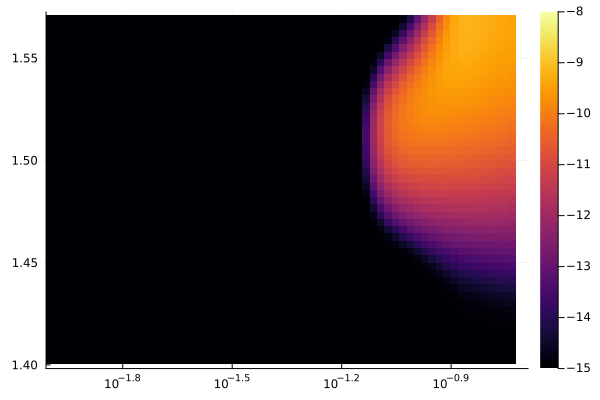

In [23]:
############################################################
# Example for calculations
##############################

ppd = ppd_t(  );
ppd.calc_coag = false;
ppd.f_sub_raw = gen_sublimation_interp(
    # "MgFeSiO4_sublimation.csv" );    
    "MgSiO3_sublimation.csv" );

r_max_au = 0.2
vr0      = 1e4;
vr_floor = 1e-1;
tlim     = r_max_au * AU / vr0 * 10;
println( "tlim = ", tlim / yr, " yr." );

f_init!( ppd, n_mbin = 20, r_min_au = 0.01, 
         r_max_au = r_max_au,
         n_r = 64, n_th = 48, th_min = 1.4,
         v0 = vr0, v_floor = vr_floor )
f_intg_ray!( ppd );

f_intg_dust!( ppd, 1e4 * yr )
f_major_loop!( ppd, nlim = 100, tlim = tlim,
               n_osd = 10, dt0 = 1e-1 * yr )

r, th, res = f_get_heatmap_stat!( ppd::ppd_t, f_rho_m );
heatmap( r, th, transpose( log10.( res .+ 1e-15 ) ),
         xscale = :log10, clim = ( -15, -8 ) )

############################################################

In [60]:
############################################################
# Export data for heatmap plots and other purposes
##############################


############################################################

In [22]:
############################################################
# Extract data and save for Python
##############################

function f_extract_rho_m!( ppd::ppd_t )
    res = zeros( ppd.n_r, ppd.n_th,
                 length( ppd.cdat.a_arr ) );
    for idx in CartesianIndices( ppd.data )
        if f_skip!( idx, ppd )
            continue;
        end
        i, j = Tuple( idx );
        loc  = ppd.data[ idx ];
        for l in eachindex( ppd.cdat.a_arr )
            res[ i - ppd.order, j - ppd.order,
                 l ] = loc.rho_m[ l ]
        end
    end
    return ( ppd.r_au_arr[
        ppd.order + 1 : ppd.order + ppd.n_r  ],
             ppd.theta_arr[
        ppd.order + 1 : ppd.order + ppd.n_th ],  res );
end;

r_f, th_f, d_g_ratio = f_get_heatmap_stat!(
                       ppd, f_dust_mass_ratio );
_, _, rho_g      = f_get_heatmap_stat!( ppd, f_rho_g );
_, _, rho_m_tot  = f_get_heatmap_stat!( ppd, f_rho_m );
_, _, T_res      = f_get_heatmap_stat!( ppd, f_T     );
r_c, th_c, rho_m = f_extract_rho_m!(    ppd );

npzwrite( "data_no_acc_no_coag.npz", Dict(
    "r_f" => r_f, "th_f" => th_f, "d_g_ratio" => d_g_ratio,
    "r_c" => r_c, "th_c" => th_c, "rho_m" => rho_m,
    "T" => T_res, "rho_m_tot" => rho_m_tot, "dx" => ppd.dx,
    "m_arr"
) );

############################################################

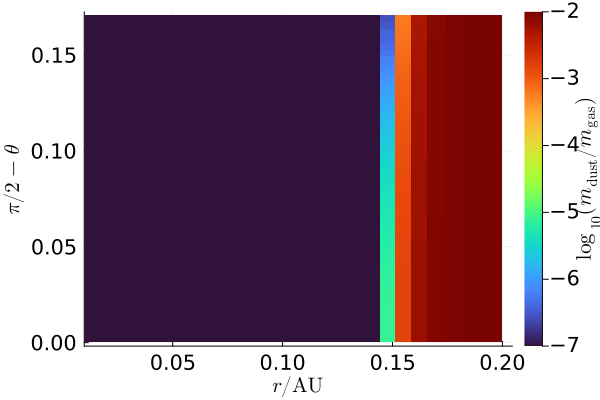

In [20]:

r, th, res = f_get_heatmap_stat!( ppd::ppd_t,
                                  f_dust_mass_ratio );
fsize = 14
heatmap( r, pi / 2 .- reverse( th, dims = 1 ), 
         reverse( transpose( log10.( res .+ 1e-15 ) ), dims = 1 ),
         # xscale = :log10,
         clim = ( -7, -2 ),  seriescolor=:turbo,
         xtickfontsize = fsize, xlabelfontsize = fsize,
         ytickfontsize = fsize, ylabelfontsize = fsize,
         xlabel=L"$r/\mathrm{AU}$", ylabel=L"$\pi/2-\theta$", 
         colorbar_title = L"$\log_{10}(m_\mathrm{dust}/m_\mathrm{gas})$",
         colorbar_titlefontsize = fsize )


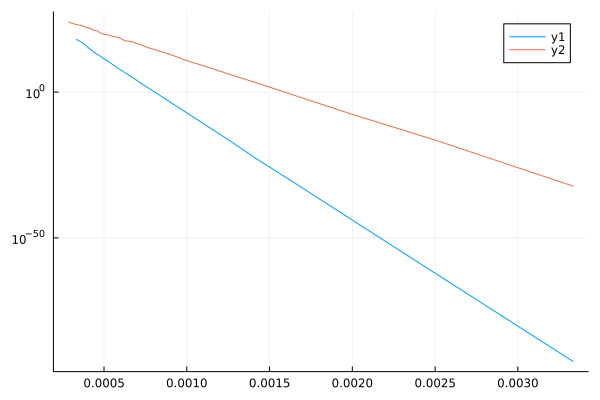

In [98]:
############################################################
# Verifications for the sublimation files
##############################

data = readdlm( "MgFeSiO4_sublimation.csv", ',',
                comments = true, comment_char = '#' )
plot( 1 ./ data[ :, 2 ], data[ :, 3 ], yaxis = :log10 )
data = readdlm( "MgSiO3_sublimation.csv", ',',
                comments = true,  comment_char = '#' )
plot!( 1 ./ data[ :, 2 ], data[ :, 3 ], yaxis = :log10 )
############################################################

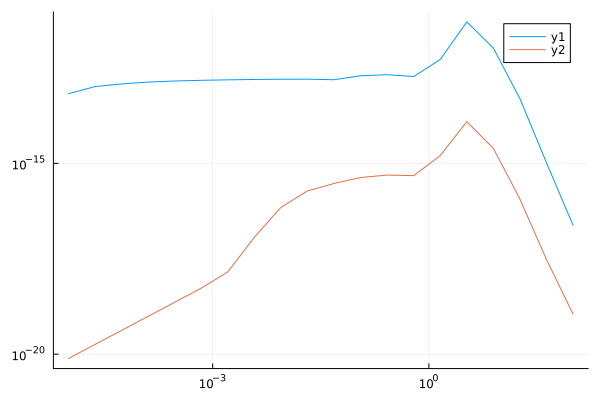

In [70]:
############################################################
# Example plot for dust size distributions somewhere
##############################

loc = ppd.data[ 27, 24 ]
plot( ppd.cdat.a_arr, abs.( loc.rho_m ),
      yaxis =:log10, xaxis =:log10 )
loc = ppd.data[ 25, 24 ]
plot!( ppd.cdat.a_arr, abs.( loc.rho_m ),
       yaxis =:log10, xaxis =:log10 )
############################################################